# ANALYSIS

In [ ]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import sklearn
import pyreadr

#statistics
from scipy.stats import chi2_contingency, ttest_ind

import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler


#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, train_test_split

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.svm import SVC #gpu-powered SVM

#Tree pruning
from sklearn.tree._tree import TREE_LEAF


#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

from collections import Counter
import os

In [2]:
# Data loader
# trainingData = pd.read_csv('../FinalData/trainingDataEncoded_08102023.csv')
# validationData = pd.read_csv('../FinalData/validationDataEncoded_08102023.csv')
# evaluationData = pd.read_csv('../FinalData/evaluationDataEncoded_08102023.csv')
# evaluationDataWales = pd.read_csv('../FinalData/evaluationDataWalesEncoded_08102023.csv')
# evaluationDataScotland = pd.read_csv('../FinalData/evaluationDataScotlandEncoded_08102023.csv')

trainingData, validationData, internalEvaluationData, evaluationData, evaluationDataWales, evaluationDataScotland = pickle.load(open('../FinalData/dataset_scaled_01122023.sav', 'rb'))

trainingData = trainingData[(trainingData.age >=8) & (trainingData.age <=80)]
validationData = validationData[(validationData.age >=8) & (validationData.age <=80)]
internalEvaluationData = internalEvaluationData[(internalEvaluationData.age >=8) & (internalEvaluationData.age <=80)]
evaluationData = evaluationData[(evaluationData.age >=8) & (evaluationData.age <=80)]
evaluationDataWales = evaluationDataWales[(evaluationDataWales.age >=8) & (evaluationDataWales.age <=80)]
evaluationDataScotland = evaluationDataScotland[(evaluationDataScotland.age >=8) & (evaluationDataScotland.age <=80)]

trainingData = trainingData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
validationData = validationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
internalEvaluationData = internalEvaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationData = evaluationData.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationDataWales = evaluationDataWales.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)
evaluationDataScotland = evaluationDataScotland.rename({'outcome_3months': '3months', 'outcome_combined_6months': '6months','outcome_combined_12months': '12months','outcome_combined_24months': '24months',}, axis=1)

In [3]:
# # Data loader
# trainingData = pd.read_csv('../FinalData/trainingDataEncoded_2vs1_16112023.csv')
# validationData = pd.read_csv('../FinalData/validationDataEncoded_2vs1_16112023.csv')
# internalEvaluationData = pd.read_csv('../FinalData/internalEvaluationDataEncoded_2vs1_16112023.csv')
# evaluationData = pd.read_csv('../FinalData/evaluationDataEncoded_2vs1_16112023.csv')
# evaluationDataWales = pd.read_csv('../FinalData/evaluationDataWalesEncoded_2vs1_16112023.csv')
# evaluationDataScotland = pd.read_csv('../FinalData/evaluationDataScotlandEncoded_2vs1_16112023.csv')

# trainingData = trainingData.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# validationData = validationData.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# internalEvaluationData = internalEvaluationData.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# evaluationData = evaluationData.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# evaluationDataWales = evaluationDataWales.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)
# evaluationDataScotland = evaluationDataScotland.rename({'3MonthsOutcome': '3months', '6MonthsOutcome': '6months','9MonthsOutcome': '9months','12MonthsOutcome': '12months',}, axis=1)

In [4]:
target_outcomes = ['12months'] 
for target_outcome in target_outcomes:
    print('#######################################################')
    print(target_outcome)
    print(trainingData[target_outcome].value_counts(normalize=True))
    print(validationData[target_outcome].value_counts(normalize=True))
    # print(internalEvaluationData[target_outcome].value_counts(normalize=True))
    print(evaluationData[target_outcome].value_counts(normalize=True))
    print(evaluationDataWales[target_outcome].value_counts(normalize=True))
    print(evaluationDataScotland[target_outcome].value_counts(normalize=True))

#######################################################
12months
0    0.8786
1    0.1214
Name: 12months, dtype: float64
0    0.878263
1    0.121737
Name: 12months, dtype: float64
0    0.831678
1    0.168322
Name: 12months, dtype: float64
0    0.842964
1    0.157036
Name: 12months, dtype: float64
0    0.811635
1    0.188365
Name: 12months, dtype: float64


In [5]:
#Define feature candidates

features_columns = trainingData.columns.to_list()
exclude_columns = ['patid', 'practice_id', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '9months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'cat_age', 'cat_average_daily_dose_ICS', 'cat_prescribed_daily_dose_ICS', 'cat_ICS_medication_possesion_ratio', 'cat_numOCS', 'cat_numOCSEvents', 
                   'cat_numOCSwithLRTI', 'cat_numAcuteRespEvents', 'cat_numAntibioticsEvents', 'cat_numAntibioticswithLRTI', 'cat_numAsthmaAttacks', 'cat_numHospEvents', 
                   'cat_numPCS', 'cat_numPCSAsthma', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                   
                   'numOCSEvents', #duplicate with numOCS
                   
                   'month_12', 'month_4', 'month_5', 'month_10', 'month_1', 'month_6', 'month_3', 
                   'month_11', 'month_8', 'month_9', 'month_7', 'month_2', #month of attacks
                   
                   # 'system_EMIS', 'system_SystemOne', 'system_Vision', #primary care system used
                  ]
exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  67
['sex', 'age', 'CharlsonScore', 'BTS_step', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numOCS', 'PriorEducation', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'ethnic_group_Asian - ethnic group', 'ethnic_group_Black - ethnic group', 'ethnic_group_Mixed ethnic census group', 'ethnic_group_Other ethnic group', 'ethnic_group_White - ethnic group', 'ethnic_group_not_recorded', 'smokingStatus_Active Smoker', 'smokingStatus_Former Smoker', 'smokingStatus_Non Smoker', 'DeviceType_BAI', 'DeviceType_DPI', 'DeviceType_NEB', 'DeviceType_pMDI', 'DeviceType_unknown', 'cat_BMI_normal', 'cat_BMI_not recorded', 'cat_BMI_obese', 'cat_BMI_overweight', 'cat_BMI_underweight', 'imd_decile_0', 'imd_decile_1', 

# UTILS

In [12]:
#Model evaluation function

def summariseResult (testX, testY, model):
    preds = model.predict_proba(testX)[:,1]
    # preds = [x[1] for x in preds]
    # tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    # specificity = tn / (tn+fp)
    # sensitivity = tp / (tp+fn)
    # ppv = 100*tp/(tp+fp)
    # npv = 100*tn/(fn+tn)
    # acc = accuracy_score(testY, preds)
    # f1score = f1_score(testY, preds, average = 'binary')
    # balanceacc = balanced_accuracy_score(testY, preds)
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    # aucscore = auc(fpr, tpr)
    aucscore = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(aucscore,4), np.round(auprc,4)
    # return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)

#Fix model name for visualisation

def modelNameFixer(x):
    if 'liblinear' in x:
        return 'Lasso'
    elif 'GaussianNB' in x:
        return 'GNB'
    elif 'SVC' in x:
        return 'SVC'
    elif 'RandomForest' in x:
        return 'RF'
    elif 'XGB' in x:
        return 'XGBoost'
    elif 'DecisionTree' in x:
        return 'DT'
    else:
        return 'LR'
    
    
# instantiate the model (using the default parameters)
def build_models (X_train, y_train, target_outcome, params_dict, model_fodler, fold):
    models = [] #list to store all the models
    print("Building models . . . .")

    #LR
    model = 'LR'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    lr_model = LogisticRegression(class_weight='balanced', C = params['C'], max_iter=params['max_iter'], solver=params['solver'], random_state=1234)
    lr_model.fit(X_train,y_train)
    pickle.dump(lr_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]]) 
    print("LR done")

    #Lasso
    model = 'Lasso'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    lasso_model = LogisticRegression(class_weight='balanced',  C = params['C'], max_iter=params['max_iter'], penalty='l1', solver=params['solver'], random_state=1234) #only the LIBLINEAR and SAGA (added in v0.19) solvers handle the L1 penalty
    lasso_model.fit(X_train, y_train)
    pickle.dump(lasso_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("Lasso done")
    
    #Elastics
    model = 'Elastics'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    elastics_model = LogisticRegression(class_weight='balanced', solver='saga', l1_ratio=params['l1_ratio'], max_iter=params['max_iter'],  penalty = 'elasticnet', random_state=1234)
    elastics_model.fit(X_train, y_train)
    pickle.dump(elastics_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("Elastics done")

    # #GNB
    # model = 'NB'
    # params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # # params = eval(params)
    # print(params)
    # gnb_model = GaussianNB(var_smoothing = params['var_smoothing'])
    # gnb_model.fit(X_train, y_train)
    # pickle.dump(gnb_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))  
    # models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    # print("GNB done")

    # # #SVM
    # model = 'SVM'
    # params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # # params = eval(params)
    # print(params)
    # svc_model = SVC(class_weight='balanced', C = params['C'], gamma=params['gamma'], kernel='rbf', random_state=1234, cache_size=1000)
    # svc_model.fit(X_train,y_train)
    # pickle.dump(svc_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb')) 
    # models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    # print("SVM done")

    #DT
    model = 'DT'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=params['max_depth'], criterion=params['criterion'], splitter=params['splitter'], random_state=1234)
    dt_model.fit(X_train, y_train)
    pickle.dump(dt_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))    
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("DT done")

    #RF
    model = 'RF'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    rf_model = RandomForestClassifier(class_weight='balanced', max_depth=params['max_depth'], criterion=params['criterion'], n_estimators=params['n_estimators'], random_state=1234)
    rf_model.fit(X_train, y_train)
    pickle.dump(rf_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb'))     
    models.append([model + str(fold), target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("RF done")

    #XGB
    model = 'XGB'
    params = params_dict[(params_dict['outcome']==target_outcome)&(params_dict['model']==model)]['params'].tolist()[0]
    # params = eval(params)
    print(params)
    scale_pos_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
    xgb_model = xgb.XGBClassifier(objective ='binary:logistic', max_depth = params['max_depth'], n_estimators = params['n_estimators'],   
                                  learning_rate=params['learning_rate'], reg_alpha = params['reg_alpha'], reg_lambda = params['reg_lambda'],
                                  importance_type = 'gain', scale_pos_weight = scale_pos_ratio, use_label_encoder=False, tree_method='gpu_hist', 
                                  gpu_id=0, verbosity = 0, random_state = 1234,)
    # xgb_model = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.001, tree_method='gpu_hist', gpu_id=0,  verbosity = 0, random_state = 1234)
    xgb_model.fit(X_train,y_train)
    pickle.dump(xgb_model, open(model_folder+ target_outcome + '/'+ model + str(fold) + '.sav', 'wb')) 
    models.append([model + str(fold),  target_outcome, y_train.value_counts()[1]/y_train.value_counts()[0]])
    print("XGB done")
    
    return models
    # return [xgb_model]

    


def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

In [13]:
# class imbalance handling method:
def handling_imbalance(method, X, y, rate):
    
    if method == 0:
        name = 'original'
        return name, X, y
    elif method == 1:
        name = 'Original-class_weight'
        return name, X, y    
    elif method == 2:
        name = 'SMOTE_' + str(rate)
        oversample = SMOTE(sampling_strategy=rate, random_state=1234)
        X_train, y_train = oversample.fit_resample(X, y)
        return name, X_train, y_train
    elif method == 3:
        name = 'Borederline-SMOTE_' + str(rate)
        oversample = BorderlineSMOTE(sampling_strategy=rate, random_state=1234)
        X_train, y_train = oversample.fit_resample(X, y)
        return name, X_train, y_train
    elif method == 4:
        name = 'Adasyn-SMOTE_' + str(rate)
        oversample = ADASYN(sampling_strategy=rate, random_state=1234)
        X_train, y_train = oversample.fit_resample(X, y)
        return name, X_train, y_train
    elif method == 5:
        name = 'Boderline-SMOTE SVM_' + str(rate)
        oversample = SVMSMOTE(sampling_strategy=rate, random_state=1234)
        X_train, y_train = oversample.fit_resample(X, y)
        return name, X_train, y_train

#Fix model name for visualisation

def modelNameFixer(x):
    if 'LR' in x:
        return 'LR'
    elif 'XGB' in x:
        return 'XGB'

    
# instantiate the model (using the default parameters)
def build_models (outcome, X, y, split_counter, params, stage ):
    models = [] #list to store all the models
    print("Building models . . . .")
    
    for i in range(6):
        if stage=='gs':
            rates = [.3, .5, .7, 1]
        else:
            rates = [.5]
        for rate in rates:
            imbalance_method, X_train, y_train = handling_imbalance(i, X, y, rate)
            print(imbalance_method)

            #LR
            if imbalance_method == 'Original-class_weight':
                lr_model = LogisticRegression(class_weight='balanced', random_state=1234)
            else:
                lr_model = LogisticRegression(random_state=1234)

            lr_model.fit(X_train,y_train)
            modelname =str(split_counter) + 'LRModel_' + imbalance_method + str(rate)
            models.append([modelname, y_train.value_counts()[1]/y_train.value_counts()[0], imbalance_method, split_counter])
            if stage == 'gs':
                pickle.dump(lr_model, open('../Models/classImbalance_gs/'+ modelname + '.sav', 'wb')) 
            else:
                pickle.dump(lr_model, open('../Models/classImbalance/'+ modelname + '.sav', 'wb')) 
            print("LR done")



            #XGB
            if imbalance_method == 'Original-class_weight':
                scale_pos_ratio = y.value_counts()[0]/y.value_counts()[1]
                print(scale_pos_ratio)
                xgb_model = xgb.XGBClassifier(objective ='binary:logistic', max_depth = params['depth'], tree_method='gpu_hist', learning_rate = 1e-2, importance_type = 'gain',
                                              use_label_encoder=False, n_estimators = 300, scale_pos_weight = scale_pos_ratio,  gpu_id=0,  verbosity = 0, random_state = 1234)
            else:
                xgb_model = xgb.XGBClassifier(objective ='binary:logistic', max_depth = params['depth'], tree_method='gpu_hist', learning_rate = 1e-2, importance_type = 'gain',
                                              use_label_encoder=False, n_estimators = 300, gpu_id=0,  verbosity = 0, random_state = 1234)
            xgb_model.fit(X_train,y_train)
            #save model
            modelname = str(split_counter) + 'XGBoostModel' + imbalance_method + str(rate)
            models.append([modelname, y_train.value_counts()[1]/y_train.value_counts()[0], imbalance_method, split_counter])
            if stage=='gs':
                pickle.dump(xgb_model, open('../Models/classImbalance_gs/'+ modelname + '.sav', 'wb')) 
            else:
                pickle.dump(xgb_model, open('../Models/classImbalance/'+ modelname + '.sav', 'wb')) 
            print("XGB done")
    
    return models
    # return [xgb_model]

In [14]:
X = trainingData[features_columns]
X_val = validationData[features_columns]
# X = pd.concat([X, X_val])

X_internaleval = internalEvaluationData[features_columns]
X_eval = evaluationData[features_columns]
X_eval_Wales = evaluationDataWales[features_columns]
X_eval_Scotland = evaluationDataScotland[features_columns]

X = X.astype(np.float64)
X_val = X_val.astype(np.float64)
X_internaleval = X_internaleval.astype(np.float64)
X_eval = X_eval.astype(np.float64)
X_eval_Wales = X_eval_Wales.astype(np.float64)
X_eval_Scotland = X_eval_Scotland.astype(np.float64)

print(X.shape)
print(X_val.shape)
print(X_internaleval.shape)
print(X_eval.shape)
print(X_eval_Wales.shape)
print(X_eval_Scotland.shape)

# target_outcomes = ['3months', '6months', '12months', '24months'] 
outcome = '12months'
y = trainingData[[outcome]]
y_val = validationData[[outcome]]
y_internaleval = internalEvaluationData[[outcome]]
y_eval = evaluationData[[outcome]]
y_eval_Wales = evaluationDataWales[[outcome]]
y_eval_Scotland = evaluationDataScotland[[outcome]]

y = y.astype(np.float64)
y_val = y_val.astype(np.float64)
y_internaleval = y_internaleval.astype(np.float64)
y_eval = y_eval.astype(np.float64)
y_eval_Wales = y_eval_Wales.astype(np.float64)
y_eval_Scotland = y_eval_Scotland.astype(np.float64)

# y = pd.concat([y, y_val])

(388879, 67)
(121393, 67)
(97036, 67)
(23859, 67)
(15264, 67)
(8595, 67)


# search

In [ ]:
ignore_X,  X_gs, ignore_y, y_gs = train_test_split(X, y, stratify=y, test_size=.05, random_state=1234)
X_gs_train, X_gs_val, y_gs_train, y_gs_val = train_test_split(X_gs, y_gs, stratify=y_gs, test_size=.3, random_state=1234)
X_gs_train = X_gs_train.astype(np.float64)
X_gs_val = X_gs_val.astype(np.float64)
y_gs_train = y_gs_train.astype(np.float64)
y_gs_val = y_gs_val.astype(np.float64)
print(X_gs_train.shape)
print(y_gs_train.shape)
print(X_gs_val.shape)
print(y_gs_val.shape)

In [ ]:
y_eval_Wales.value_counts()[0]/y_eval_Wales.value_counts()[1]

In [ ]:
trainingData = trainingData.dropna()
trainingData.reset_index(drop=True, inplace=True)

# features = [item for item in trainingData.columns if item not in outcomes]
# X = trainingData[features]
summary_result = []
# cols = ['model_name', 'class_ratio', 'outcome', 'imbalance_method', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
cols = ['model_name', 'class_ratio', 'outcome', 'imbalance_method', 'auc', 'auprc']
#params for XGB
params = {'12months':{'depth': 4
                     },
         }

# print('X shape: ', X.shape)
# print('y shape: ', y.shape)
models = pd.DataFrame(columns=['modelname', 'class_ratio', 'imbalance_method', 'split_counter'])

split_counter = 0

#train model

#Build models -> it can be commented if the models have been trained
models_temp = pd.DataFrame(build_models(outcome, X_gs_train, y_gs_train[outcome], split_counter, params[outcome], 'gs'), columns=['modelname', 'class_ratio', 'imbalance_method', 'split_counter'])
models = pd.concat([models,models_temp]).reset_index(drop=True)


#evaluate model
for modelname, classratio, imbalance_method, split_counter in models_temp.values:
    # print('======================================================================')
    print(modelname)
    model = pickle.load(open('../Models/classImbalance_gs/'+ modelname + '.sav', 'rb'))
    summary_result.append((modelname, classratio, outcome, imbalance_method) + summariseResult (X_gs_val, y_gs_val[outcome], model) )     

split_counter+=1


summary_result = pd.DataFrame(summary_result, columns=cols)
summary_result['model_num'] = summary_result.index

In [ ]:
summary_result

In [ ]:
summary_result['model_name1'] = summary_result.model_name.apply(lambda x: modelNameFixer(x))

In [ ]:
bar = sns.catplot(x = "model_name1",       # x variable name
            y = "auc",       # y variable name            
            data = summary_result[(summary_result.outcome==outcome)&(summary_result.model_name1=='XGB')],     # dataframe to plot
            kind = "bar",
            hue = 'imbalance_method',
            height=5,
            aspect=5/2.5,
            ci = None)
bar.set(title=outcome)
ax = bar.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.01, 
            p.get_height() * 1.01, 
            '{0:.4f}'.format(p.get_height()), 
            color='black', rotation='horizontal', fontsize=11)

# listOf_Yticks = np.arange(0.5, 0.7, 0.05)
ax.set_ylim(0.5, .8)
ax.set_ylabel('AUC Score', fontsize=11)
ax.set_xlabel('Method', fontsize=11)
ax

# Train MOdel

In [15]:
# trainingData = trainingData.dropna()
# trainingData.reset_index(drop=True, inplace=True)
n_splits = 3
# features = [item for item in trainingData.columns if item not in outcomes]
# X = trainingData[features]
summary_result = []
# cols = ['model_name', 'class_ratio', 'outcome', 'imbalance_method', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
cols = ['model_name', 'class_ratio', 'outcome', 'imbalance_method', 'auc', 'auprc']
#params for XGB
params = {'12months':{'depth': 4,
                     },
         }

# print('X shape: ', X.shape)
# print('y shape: ', y.shape)
models = pd.DataFrame(columns=['modelname', 'class_ratio', 'imbalance_method', 'split_counter'])
kf = StratifiedKFold(n_splits=n_splits, random_state=1234, shuffle=True)
kf.get_n_splits(X_internaleval)

split_counter = 0

#train model
for train_index, test_index in kf.split(X_internaleval, y_internaleval):
    #split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(outcome, X_train, y_train[outcome], split_counter, params[outcome], 'train'), columns=['modelname', 'class_ratio', 'imbalance_method', 'split_counter'])
    models = pd.concat([models,models_temp]).reset_index(drop=True)


    #evaluate model
    for modelname, classratio, imbalance_method, split_counter in models_temp.values:
        # print('======================================================================')
        print(modelname)
        model = pickle.load(open('../Models/classImbalance/'+ modelname + '.sav', 'rb'))
        summary_result.append((str(modelname), classratio, outcome, imbalance_method) + summariseResult (X_eval, y_eval[outcome], model) )     

    split_counter+=1


summary_result = pd.DataFrame(summary_result, columns=cols)
summary_result['model_num'] = summary_result.index

Building models . . . .
original


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Original-class_weight


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
7.357881136950905
XGB done
SMOTE_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Borederline-SMOTE_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Adasyn-SMOTE_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Boderline-SMOTE SVM_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
0LRModel_original0.5
0XGBoostModeloriginal0.5
0LRModel_Original-class_weight0.5
0XGBoostModelOriginal-class_weight0.5
0LRModel_SMOTE_0.50.5
0XGBoostModelSMOTE_0.50.5
0LRModel_Borederline-SMOTE_0.50.5
0XGBoostModelBorederline-SMOTE_0.50.5
0LRModel_Adasyn-SMOTE_0.50.5
0XGBoostModelAdasyn-SMOTE_0.50.5
0LRModel_Boderline-SMOTE SVM_0.50.5
0XGBoostModelBoderline-SMOTE SVM_0.50.5
Building models . . . .
original


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Original-class_weight


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
7.320385852090032
XGB done
SMOTE_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Borederline-SMOTE_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Adasyn-SMOTE_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Boderline-SMOTE SVM_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
1LRModel_original0.5
1XGBoostModeloriginal0.5
1LRModel_Original-class_weight0.5
1XGBoostModelOriginal-class_weight0.5
1LRModel_SMOTE_0.50.5
1XGBoostModelSMOTE_0.50.5
1LRModel_Borederline-SMOTE_0.50.5
1XGBoostModelBorederline-SMOTE_0.50.5
1LRModel_Adasyn-SMOTE_0.50.5
1XGBoostModelAdasyn-SMOTE_0.50.5
1LRModel_Boderline-SMOTE SVM_0.50.5
1XGBoostModelBoderline-SMOTE SVM_0.50.5
Building models . . . .
original


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Original-class_weight


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
7.346148884014966
XGB done
SMOTE_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Borederline-SMOTE_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Adasyn-SMOTE_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
Boderline-SMOTE SVM_0.5


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/rapids/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR done
XGB done
2LRModel_original0.5
2XGBoostModeloriginal0.5
2LRModel_Original-class_weight0.5
2XGBoostModelOriginal-class_weight0.5
2LRModel_SMOTE_0.50.5
2XGBoostModelSMOTE_0.50.5
2LRModel_Borederline-SMOTE_0.50.5
2XGBoostModelBorederline-SMOTE_0.50.5
2LRModel_Adasyn-SMOTE_0.50.5
2XGBoostModelAdasyn-SMOTE_0.50.5
2LRModel_Boderline-SMOTE SVM_0.50.5
2XGBoostModelBoderline-SMOTE SVM_0.50.5


In [31]:
summary_result['model_name'] = summary_result.model_name.apply(lambda x: modelNameFixer(x))
summary_result['imbalance_method'] = summary_result.imbalance_method.apply(lambda x: x.replace('_0.5', ''))

/tmp/ipykernel_19091/2402672686.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar = sns.catplot(x = "model_name",       # x variable name


<Axes: title={'center': '12months'}, xlabel='Method', ylabel='AUC Score'>

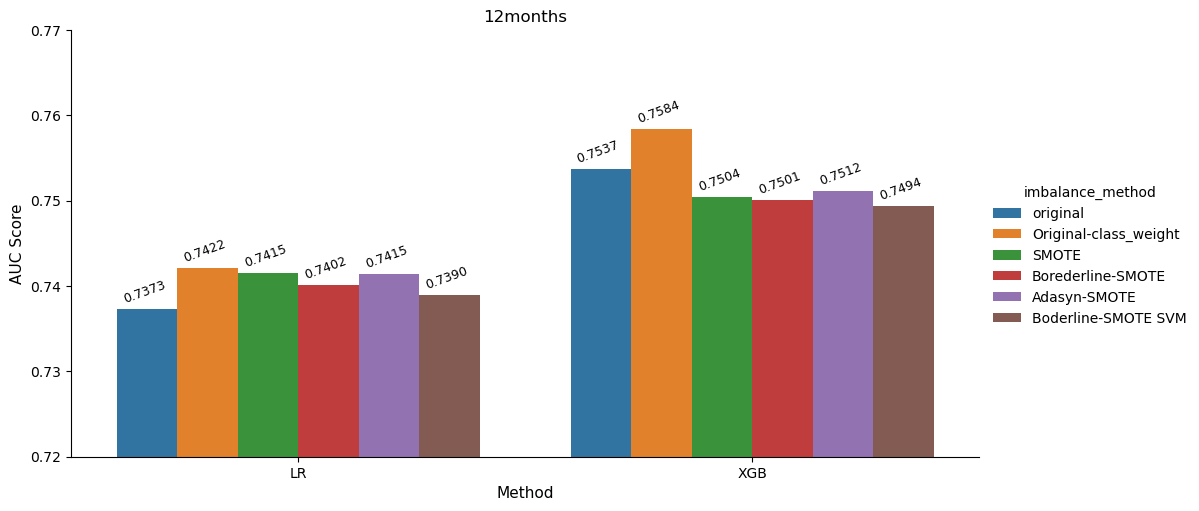

In [37]:
bar = sns.catplot(x = "model_name",       # x variable name
            y = "auc",       # y variable name            
            data = summary_result[summary_result.outcome==outcome],     # dataframe to plot
            kind = "bar",
            hue = 'imbalance_method',
            height=5,
            aspect=5/2.5,
            ci = None)
bar.set(title=outcome)
ax = bar.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.01, 
            p.get_height() * 1.001, 
            '{0:.4f}'.format(p.get_height()), 
            color='black', rotation=20, fontsize=9)

# listOf_Yticks = np.arange(0.5, 0.7, 0.05)
ax.set_ylim(0.72, .77)
ax.set_ylabel('AUC Score', fontsize=11)
ax.set_xlabel('Method', fontsize=11)
ax

In [ ]:
summary_result